#### 1. Sources
[Face Mask First dataset](https://www.kaggle.com/datasets/andrewmvd/face-mask-detection)

[Face Mask Detection 12K Images Dataset](https://www.kaggle.com/datasets/ashishjangra27/face-mask-12k-images-dataset)

[Haarcascade Models](https://www.kaggle.com/datasets/lalitharajesh/haarcascades)

[Caffe Face Detection Model](https://www.kaggle.com/datasets/sambitmukherjee/caffe-face-detector-opencv-pretrained-model)

**Objective:**

Identiying if a person is wearing facemask or not

In [1]:
## Importing libraries
import pandas as pd
import numpy as np
import cv2
import os
import glob
from scipy.spatial import distance
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import seaborn as sns

2023-05-08 06:12:19.479216: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-08 06:12:19.494895: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-08 06:12:19.581587: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-08 06:12:19.582297: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-08 06:12:20.186587: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

### Getting the directories, Path and Data

In [2]:
path = "Face Mask Dataset/"

In [3]:
dataset = {
    "image_path": [],
    "mask_status": [],
    "where": []
}

for where in os.listdir(path):
    for status in os.listdir(path+"/"+where):
        for image in glob.glob(path+where+"/"+status+"/"+"*.png"):
            dataset["image_path"].append(image)
            dataset["mask_status"].append(status)
            dataset["where"].append(where)
            
dataset = pd.DataFrame(dataset)
dataset.head()

,image_path,mask_status,where
0,Face Mask Dataset/Train/WithMask/Augmented_313...,WithMask,Train
1,Face Mask Dataset/Train/WithMask/1128.png,WithMask,Train
2,Face Mask Dataset/Train/WithMask/Augmented_191...,WithMask,Train
3,Face Mask Dataset/Train/WithMask/Augmented_531...,WithMask,Train
4,Face Mask Dataset/Train/WithMask/Augmented_505...,WithMask,Train


### Face Detection using HAAR Cascade Algorithm

(3, 4)


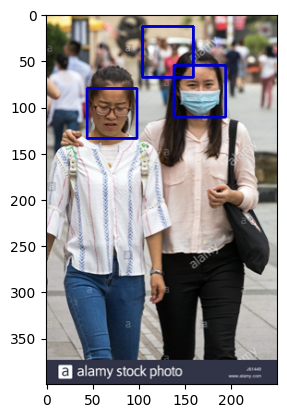

In [4]:
## Choosing a random image to detect the face in the image
face_model = cv2.CascadeClassifier('haarcasacdes/haarcascade_frontalface_default.xml')

## Choosing the image from the directory
img = cv2.imread("Medical Faces/images/maksssksksss352.png")

## Converting the image to grayscale to apply haarcascade algorithm
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

## Returns the x, y, w, h co-ordinates as numpy arrays for all the detected faces
detected_face = face_model.detectMultiScale(img)

## Converting from grayscale to colored image
output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

## Drawing rectangle box around the faces in the image
for (x, y, w, h) in detected_face:
    cv2.rectangle(output_img, (x,y), (x+w, y+h), (0, 0, 200), 2)
    
## Displaying the image
# plt.figure(figsize = (15, 15))
print(detected_face.shape)
plt.imshow(output_img)

### Drawbacks:
We can observe that Default face detection Haar Cascading that we choose doesnt do a good job in identifying the faces. (Will replace this with other algorithms)

### Try Another Algorithm To Detect Faces

In [5]:
cvNet = cv2.dnn.readNetFromCaffe(prototxt="model/deploy.prototxt",
                                            caffeModel="model/res10_300x300_ssd_iter_140000_fp16.caffemodel")

def cvDnnDetectFaces(image, min_confidence=0.5, display = True):
        
    image_height, image_width, _ = image.shape

    output_image = image.copy()
    
    out_images = []

    preprocessed_image = cv2.dnn.blobFromImage(image, scalefactor=1.0, size=(300, 300),
                                               mean=(104.0, 117.0, 123.0), swapRB=False, crop=False)

    cvNet.setInput(preprocessed_image)

    results = cvNet.forward()    

        
    for face in results[0][0]:
        
        face_confidence = face[2]
        
        if face_confidence > min_confidence:

            bbox = face[3:]

            x1 = int(bbox[0] * image_width)
            y1 = int(bbox[1] * image_height)
            x2 = int(bbox[2] * image_width)
            y2 = int(bbox[3] * image_height)

            out_im = output_image[y1:y2, x1:x2].copy()
            out_im = cv2.resize(out_im, (150, 150))
            out_im = cv2.cvtColor(out_im, cv2.COLOR_BGR2GRAY)
            # normalize the output
#             out_im = out_im / 255
            
            out_images.append(out_im)
            
            
            cv2.rectangle(output_image, pt1=(x1, y1), pt2=(x2, y2), color=(0, 255, 0), thickness=image_width//200)


    if display:


        plt.figure(figsize=[20,20])
        plt.subplot(121);plt.imshow(image[:,:,::-1]);plt.title("Original Image");plt.axis('off');
        plt.subplot(122);plt.imshow(output_image[:,:,::-1]);plt.title("Output");plt.axis('off');
        
    else:
        return out_images, results 

(150, 150)


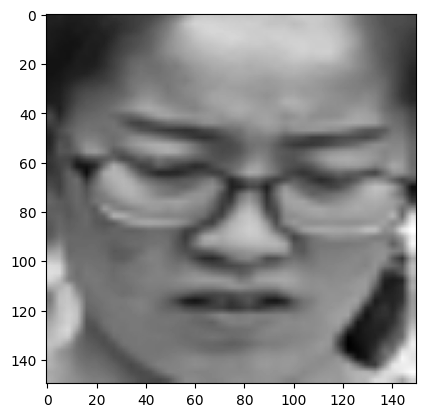

In [6]:
image =  cv2.imread("Medical Faces/images/maksssksksss352.png",1)
out, r = cvDnnDetectFaces(image, display=False)

print(out[1].shape)
plt.imshow(out[0], cmap = "gray")

### Visualization

With Mask: 5909
Without Mask: 5883


<Axes: xlabel='mask_status', ylabel='count'>

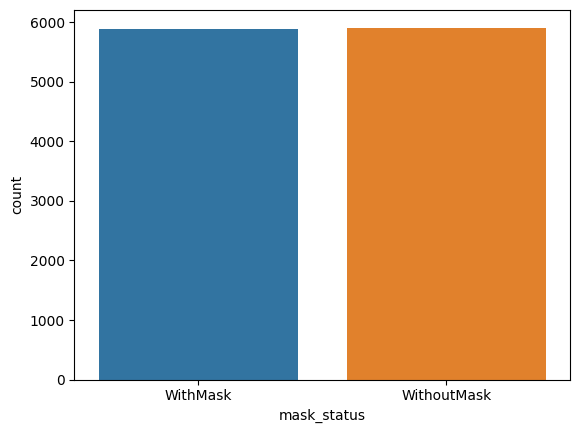

In [7]:
## Checking for total number of images in the dataset
print(f"With Mask:", dataset.value_counts("mask_status")[0])
print(f"Without Mask:", dataset.value_counts("mask_status")[1])

## Plotting the numbers
sns.countplot(x = dataset["mask_status"])

In [8]:
def getRandomSample(dataset, column="mask_status", image_path="image_path", pre=""):
    plt.figure(figsize = (15, 10))

    for i in range(9):
        random = np.random.randint(1, len(dataset))
        plt.subplot(3, 3, i+1)
        plt.imshow(cv2.imread(pre + dataset.loc[random, image_path]))
        plt.title(dataset.loc[random, column], size = 15)
        plt.xticks([])
        plt.yticks([])

    plt.show()

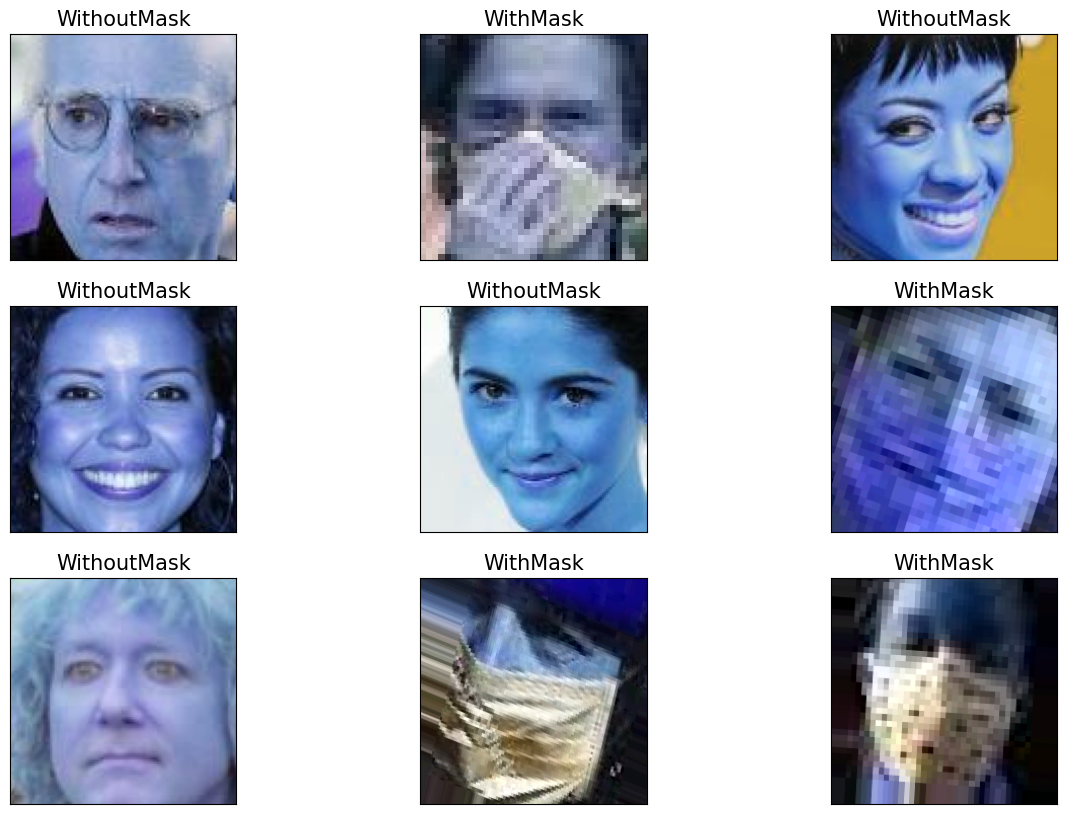

In [9]:
getRandomSample(dataset)

In [10]:
## Splitting train test and Validation Dataset
train_df = dataset[dataset["where"] == "Train"]
test_df = dataset[dataset["where"] == "Test"]
valid_df = dataset[dataset["where"] == "Validation"]

print(train_df.head(10))

## Shuffling the dataset 
train_df = train_df.sample(frac = 1)
test_df = test_df.sample(frac = 1)
valid_df = valid_df.sample(frac = 1)

print("\n After Shuffling \n")
print(train_df.head(10))

                                          image_path mask_status  where
0  Face Mask Dataset/Train/WithMask/Augmented_313...    WithMask  Train
1          Face Mask Dataset/Train/WithMask/1128.png    WithMask  Train
2  Face Mask Dataset/Train/WithMask/Augmented_191...    WithMask  Train
3  Face Mask Dataset/Train/WithMask/Augmented_531...    WithMask  Train
4  Face Mask Dataset/Train/WithMask/Augmented_505...    WithMask  Train
5           Face Mask Dataset/Train/WithMask/500.png    WithMask  Train
6          Face Mask Dataset/Train/WithMask/1316.png    WithMask  Train
7  Face Mask Dataset/Train/WithMask/Augmented_16_...    WithMask  Train
8          Face Mask Dataset/Train/WithMask/1489.png    WithMask  Train
9  Face Mask Dataset/Train/WithMask/Augmented_614...    WithMask  Train

 After Shuffling 

                                             image_path  mask_status  where
5175       Face Mask Dataset/Train/WithoutMask/2748.png  WithoutMask  Train
7463       Face Mask Dataset/Train/W

### Visualising the distribution of train test and validation set

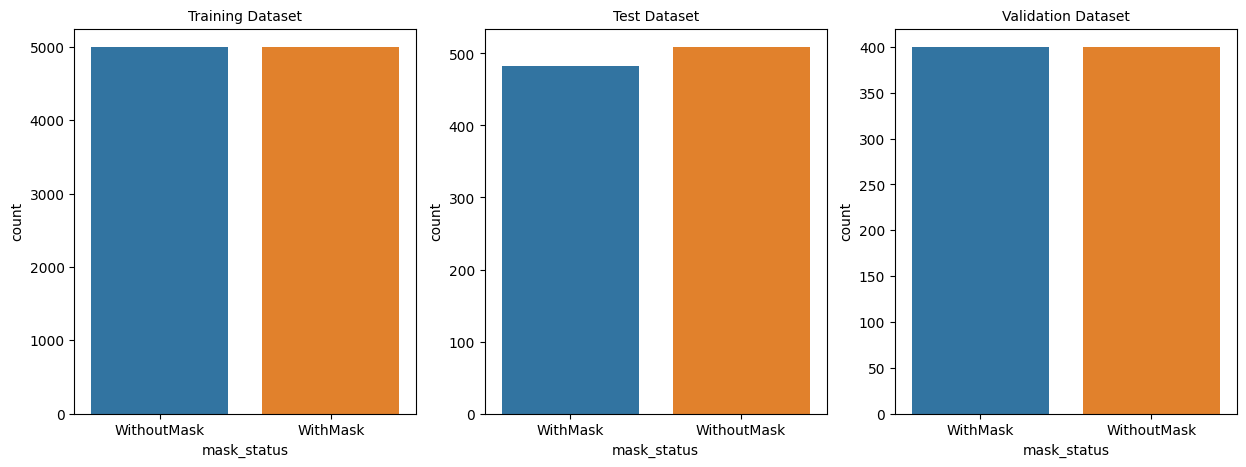

In [11]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x = train_df["mask_status"])
plt.title("Training Dataset", size = 10)

plt.subplot(1, 3, 2)
sns.countplot(x = test_df["mask_status"])
plt.title("Test Dataset", size = 10)

plt.subplot(1, 3, 3)
sns.countplot(x = valid_df["mask_status"])
plt.title("Validation Dataset", size = 10)

plt.show()

In [12]:
train_df = train_df.reset_index().drop("index", axis = 1)
train_df.head()

,image_path,mask_status,where
0,Face Mask Dataset/Train/WithoutMask/2748.png,WithoutMask,Train
1,Face Mask Dataset/Train/WithoutMask/3670.png,WithoutMask,Train
2,Face Mask Dataset/Train/WithMask/Augmented_113...,WithMask,Train
3,Face Mask Dataset/Train/WithoutMask/4270.png,WithoutMask,Train
4,Face Mask Dataset/Train/WithMask/Augmented_71_...,WithMask,Train


# Data Augmentation

In [13]:
def visualize(original, augmented):
    fig = plt.figure()
    plt.subplot(1,2,1)
    plt.title('Original image')
    plt.imshow(original)
    plt.axis("off")
 
    plt.subplot(1,2,2)
    plt.title('Augmented image')
    plt.imshow(augmented)
    plt.axis("off")

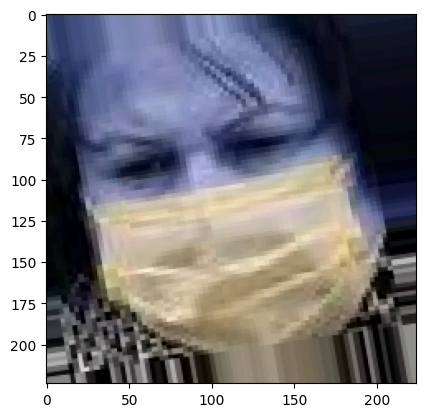

In [14]:
image = cv2.imread(dataset['image_path'][0])

plt.imshow(image)

2023-05-08 06:12:44.220412: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


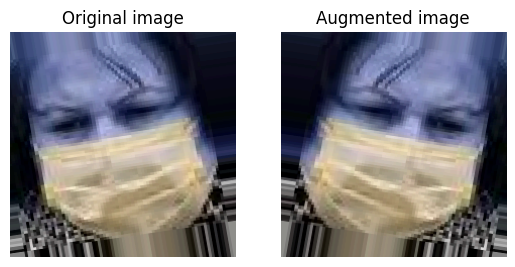

In [15]:
flipped = tf.image.flip_left_right(image)
visualize(image, flipped)

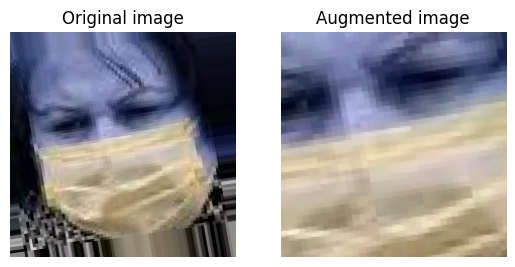

In [16]:
cropped = tf.image.central_crop(image, central_fraction=0.5)
visualize(image, cropped)

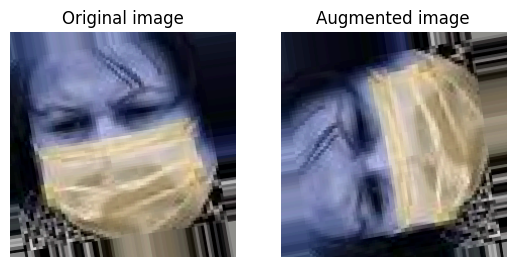

In [17]:
rotated = tf.image.rot90(image)
visualize(image, rotated)

In [18]:
def data_augmentation(image):
    image = tf.image.flip_left_right(image)
    image = tf.image.central_crop(image, central_fraction=0.5)
    image = tf.image.rot90(image)
    return image

## Reading all the image into a list and changing the size of the image to (150,150)


In [19]:
## Reading all the image into a list and changing the size of the image to (150,150)
data = []
image_size = 150

for i in range(len(train_df)):
    ## Converting the image into grayscale
    img_array = cv2.imread(train_df["image_path"][i], cv2.IMREAD_GRAYSCALE)

    ## Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    ##Encoding the image with the label
    if train_df["mask_status"][i] == "WithMask":
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [20]:
data[1]

[array([[12, 11, 11, ..., 12, 12, 12],
        [14, 13, 12, ..., 11, 12, 12],
        [18, 16, 13, ..., 10, 12, 13],
        ...,
        [36, 34, 31, ..., 49, 52, 55],
        [35, 34, 31, ..., 51, 52, 54],
        [34, 33, 31, ..., 52, 53, 53]], dtype=uint8),
 0]

In [21]:
data[0][0].shape

(150, 150)

In [22]:
## Shuffling the data to make sure everything is not in order
np.random.shuffle(data)

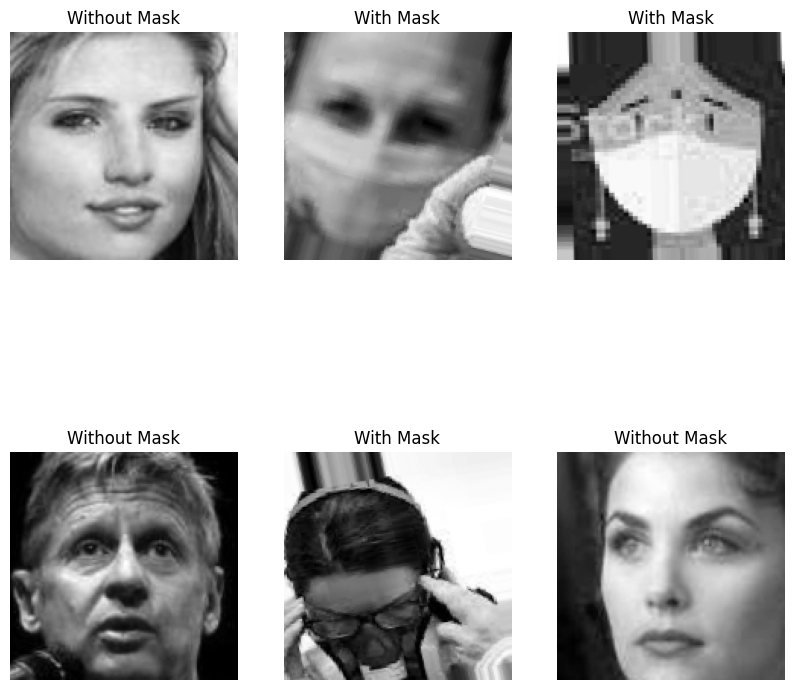

In [23]:
## Looking at the training samples

fig, ax = plt.subplots(2, 3, figsize=(10, 10))

for row in range(2):
    for col in range(3):
        image_index = row*100+col
        
        ax[row, col].axis("off")
        ax[row,col].imshow(data[image_index][0], cmap = "gray")
    
        if data[image_index][1] == 0:
            ax[row, col].set_title("Without Mask")
        else:
            ax[row, col].set_title("With Mask")
            
plt.show()

### Preparing data to be loaded into the Model

In [24]:
X = []
y = []

## Seperating X and y
for image in data:
    X.append(image[0])
    y.append(image[1])
    
## Converting X and y to numpy array as Tensorflow accepts only numpy arrays
X = np.array(X)
y = np.array(y)

## Print The Image
print(X[100].shape)

(150, 150)


## Change Color To Gray

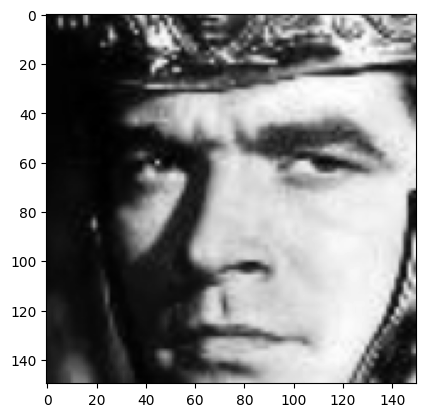

In [25]:
plt.imshow(X[4], cmap='gray')

In [26]:
### Normalizing the data
# X = X/255

### Train Test Split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [27]:
X_train.shape

(8000, 150, 150)

### Building the model

In [28]:
model = Sequential()
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(Conv2D(64, (3, 3), activation = "relu"))
model.add(MaxPool2D(pool_size=(3, 3)))
model.add(Flatten())
model.add(Dense(128, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))
# model.summary()

In [29]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [31]:
# X_train = X_train.reshape(-1, 32, 150, 150)
## Reshaping training set to match Conc2D
X_train = X_train.reshape(len(X_train), X_train.shape[1], X_train.shape[2], 1)
print(X_train.shape)
X_val = X_val.reshape(len(X_val), X_val.shape[1], X_val.shape[2], 1)

history = model.fit(X_train, y_train, epochs=5, batch_size = 32)

(8000, 150, 150, 1)
Epoch 1/5


TypeError: 'NoneType' object is not callable

In [ ]:
model.summary()

In [ ]:
model.evaluate(X_val, y_val)

In [ ]:
prediction = model.predict(X_val)

In [ ]:
predicts = []
for p in prediction:
    if p[0] > 0.6:
        predicts.append(1)
    else:
        predicts.append(0)

In [ ]:
print(classification_report(y_val, predicts))
print(confusion_matrix(y_val, predicts))

# Try Real Examples From A Different Dataset

(1, 150, 150)


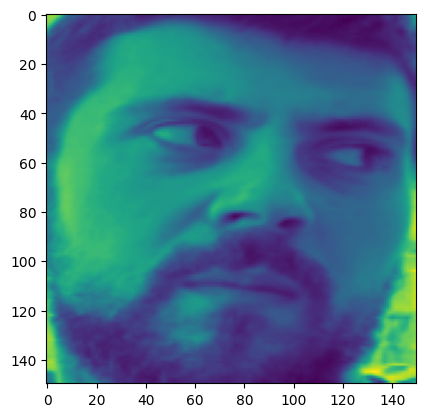

In [66]:
image =  cv2.imread("Medical Faces/images/maksssksksss14.png")
out, r = cvDnnDetectFaces(image, display=False)

# test = np.array([X_val[1]])
test = np.array(out)
print(test.shape)

# print(model.predict(np.array([X_val[100]])))
# print(model.predict(test))

plt.imshow(test[0])

## HUGE OVERFITTTING

In [ ]:
img_dir = "Medical Faces/images"
img_file_path = []
for img in os.listdir(img_dir):
    image  = cv2.imread(os.path.join(img_dir, img), 0)
    img_file_path.append(f'{img}')

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
annotation_dir = "Medical Faces/annotations"
df = { 'name': [],
        'label': [],
      'width': [],
      'height': [],
     'xmin': [],
     'ymin': [],
     'xmax': [],
     'ymax': []}

for idx, anno in enumerate(glob.glob(annotation_dir + '/*.xml')):
    trees = ET.parse(anno)
    
    #print(anno)
    root = trees.getroot()
    width, height = [], []
    for item in root.iter():
        #print(item)
               
        if item.tag == 'size':
            for attr in list(item):
                if attr.tag == 'width':
                    width = int(round(float(attr.text)))
                if attr.tag == 'height':
                    height = int(round(float(attr.text)))
                    
        if item.tag == 'object':
            for attr in list(item):
                if 'name' in attr.tag:
                    label = attr.text
                    df['label'] += [label]
                    df['width'] += [width]
                    df['height'] += [height]
                    #dataset['name']+=[anno.split('/')[-1][0:-4]] 
                    df['name'] += [anno.split('/')[-1][0:-4]]
                    
                if 'bndbox' in attr.tag:
                    for dim in attr:
                        if dim.tag == 'xmin':
                            xmin = int(round(float(dim.text)))
                            df['xmin'] += [xmin]
                            
                        if dim.tag == 'ymin':
                            ymin = int(round(float(dim.text)))
                            df['ymin'] += [ymin]
                        if dim.tag == 'xmax':
                            xmax = int(round(float(dim.text)))
                            df['xmax'] += [xmax]
                        if dim.tag == 'ymax':
                            ymax = int(round(float(dim.text)))
                            df['ymax'] += [ymax]

In [ ]:
df1 = pd.DataFrame(df)
df1.head()

In [ ]:
df1.info()

In [ ]:
label_map = { 'without_mask': 0,
            'with_mask': 1,
            'mask_weared_incorrect': 2}

df1['class'] = df1['label'].map(label_map)

In [ ]:
df1.head()

In [ ]:
df1 = df1[df1['class'] != 2]
df1 = df1.reset_index()
df1.head()

In [ ]:
df1[df1['name'] == "maksssksksss148"]

In [ ]:
df1['new_name'] = ""
df1

In [ ]:
# for i in df1:
save_to = "Image Enhanced"
c = 0
for i in range(len(df1)):
    print(i)
    image =  cv2.imread(f"{img_dir}/{df1['name'][i]}.png", 1)
    try:
        image = image[
            df1['xmin'][i]:df1['xmax'][i],
            df1['ymin'][i]:df1['ymax'][i]
        ]

        plt.imshow(image)
        cv2.imwrite(f"{save_to}/{df1['name'][i]}_{i}.png", image)
        df1['new_name'][i] = f"{df1['name'][i]}_{i}.png"
    except:
        c += 1
        continue

In [ ]:
df1.columns

In [ ]:
df1.head()

In [ ]:
df1 = df1[df1['new_name'] != ""]
df1 = df1.reset_index()
df1

In [ ]:
print(f"With Mask:", df1.value_counts("class")[0])
print(f"Without Mask:", df1.value_counts("class")[1])

In [ ]:
getRandomSample(df1, column="class", image_path="new_name", pre="Image Enhanced/")

In [ ]:
data = []
image_size = 150

for i in range(len(df1)):
    ## Converting the image into grayscale
    img_array = cv2.imread(f"{save_to}/{df1['new_name'][i]}", cv2.IMREAD_GRAYSCALE)

    ## Resizing the array
    new_image_array = cv2.resize(img_array, (image_size, image_size))

    ##Encoding the image with the label
    if df1["class"][i] == 1:
        data.append([new_image_array, 1])
    else:
        data.append([new_image_array, 0])

In [ ]:
len(data)